# Data collection


As usual let’s start with imports.

In [1]:
pip install iisignature

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=3245484 sha256=10fc6941e69da7a4fc5f3054cb1dcd13e45f9b98c3f2edd594679a9eb0f6e1db
  Stored in directory: /root/.cache/pip/wheels/c8/13/d1/42e1aa7f8a8e1189360df53c461f0e13f43e0d2170ef16d349
Successfully built iisignature


In [54]:
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import copy
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import LSTM, RepeatVector
import iisignature

# Function to calculate lead-lag transformation
def leadlag(data, use_time=False):
    if use_time:
        time_component = np.arange(len(data))
        data = np.c_[time_component, data]
    lead = np.roll(data, -1, axis=0)
    lag = np.roll(data, 1, axis=0)
    leadlag_path = np.c_[data, lead, lag]
    return leadlag_path

# Function to calculate log signature
def stream_to_logsig(X, order):
    X = np.array(X)
    s = iisignature.prepare(X.shape[1], order)
    return iisignature.logsig(X, s)

# Class for data extraction and processing
class MarketGenerator:
    def __init__(self, n_dims, tickers_array, start, end, freq, signature_order, data_transform):
        self.n_dims = n_dims
        self.tickers_array = tickers_array
        self.start = start
        self.end = end
        self.freq = freq
        self.order = signature_order
        self.data_transform = data_transform

        print("Loading data...")
        self.load_data()
        print("Building dataset...")
        self.build_dataset()
        print("Transforming dataset...")
        self.transform_dataset()
        print("Calculating log signatures...")
        self.calculate_signatures()
        print("Scaling dataset...")
        self.scale_dataset()

    def load_data(self):
        self.data_array = []
        for ticker in self.tickers_array:
            try:
                print(f"Downloading data for ticker: {ticker}")
                data = yf.download(ticker, start=self.start, end=self.end)["Close"]
                self.data_array.append(data)
            except Exception as e:
                print(f"Error downloading data for {ticker}: {e}")
                self.data_array.append(None)

        self.windows_array = []
        for idx, data in enumerate(self.data_array):
            if data is not None:
                windows = []
                for _, window in data.resample(self.freq):
                    if not window.empty:
                        # Ensure `window` is always treated as a `DataFrame`
                        windows.append(window)
                self.windows_array.append(windows)
            else:
                print(f"No data available for ticker {self.tickers_array[idx]}")
                self.windows_array.append([])

    def build_dataset(self):
        self.paths = []

        for i in range(len(self.windows_array[0])):  # Iterate over windows
            if self.n_dims > 1:
                try:
                    # Start with the first dimension's data
                    df = self.windows_array[0][i]
                    for n in range(1, self.n_dims):  # Merge data from other dimensions
                        if i < len(self.windows_array[n]):
                            df = pd.merge(
                                df,
                                self.windows_array[n][i],
                                left_index=True,
                                right_index=True,
                                suffixes=('', f'_dim{n}')
                            )
                        else:
                            raise IndexError(f"Dimension {n} is missing window {i}")
                    path = df.values
                except Exception as e:
                    print(f"Error merging windows at index {i}: {e}")
                    path = None
            else:
                path = self.windows_array[0][i].values

            if path is not None:
                # Normalize data safely
                normalized_path = path / np.maximum(path.max(), 1e-8)  # Avoid division by zero
                self.paths.append(normalized_path)

    def transform_dataset(self):
        self.transformed_paths = []
        for path in self.paths:
            self.transformed_paths.append(self.data_transform(path))

    def calculate_signatures(self):
        self.orig_logsig = np.array([stream_to_logsig(path, self.order) for path in tqdm(self.transformed_paths)])

    def scale_dataset(self):
        self.scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
        scaled_logsig = self.scaler.fit_transform(self.orig_logsig)

        self.logsigs = scaled_logsig[1:]
        self.conditions = scaled_logsig[:-1]  # Needed later for CVAE



# Class for Organism
class Organism:
    def __init__(self, n_points, n_dims, data_transform, distribution_array):
        self.n_points = n_points
        self.n_dims = n_dims
        self.data_transform = data_transform

        self.distribution_array = distribution_array

        self.init_path()

    def __add__(self, other):
        increments = []
        for increment1, increment2 in zip(self.increments, other.increments):
            if np.random.random() < 0.5:
                increments.append(increment1)
            else:
                increments.append(increment2)

        path = np.cumsum(increments, axis=0)
        transformed_path = self.data_transform(path)

        child = Organism(self.n_points, self.n_dims, self.data_transform, self.distribution_array)
        child.increments = increments
        child.path = path
        child.transformed_path = transformed_path

        return child

    def random_increment(self):
        r = []
        for dim in range(self.n_dims):
            r.append(self.distribution_array[dim]())
        return np.array(r)

    def init_path(self):
        self.increments = np.array([self.random_increment() for _ in range(self.n_points)])
        path = np.cumsum(self.increments, axis=0)
        transformed_path = self.data_transform(path)
        self.path = path
        self.transformed_path = transformed_path

    def mutate(self, prob=0.1):
        for i in range(len(self.increments)):
            if np.random.random() < prob:
                self.increments[i] = self.random_increment()

        path = np.cumsum(self.increments, axis=0)
        transformed_path = self.data_transform(path)
        self.path = path
        self.transformed_path = transformed_path

    def logsignature(self, order):
        return stream_to_logsig(self.transformed_path, order)

    def loss(self, logsig, order):
        diff = np.abs((logsig - self.logsignature(order)) / logsig)
        diff /= 1 + np.arange(len(logsig))
        return np.mean(diff)

# Class for Population
class Population:
    def __init__(self, n_organisms, n_points, n_dims, data_transform, distribution_array):
        self.n_organisms = n_organisms
        self.n_points = n_points
        self.n_dims = n_dims
        self.data_transform = data_transform
        self.distribution_array = distribution_array
        self.organisms = [Organism(n_points, n_dims, data_transform, distribution_array) for _ in range(n_organisms)]

    def fittest(self, logsig, p, order):
        n = int(len(self.organisms) * p)
        return sorted(self.organisms, key=lambda o: o.loss(logsig, order))[:n]

    def evolve(self, logsig, p, order, mutation_prob=0.1):
        parents = self.fittest(logsig, p, order)
        new_generation = copy.deepcopy(parents)

        while len(new_generation) != self.n_organisms:
            i, j = np.random.choice(range(len(parents)), size=2, replace=False)
            parent1, parent2 = parents[i], parents[j]
            child = parent1 + parent2
            child.mutate(prob=mutation_prob)
            new_generation.append(copy.deepcopy(child))

        self.organisms = new_generation
        return min(o.loss(logsig, order) for o in new_generation)

    @staticmethod
    def train(logsig, order, n_iterations, n_organisms, n_points, n_dims, data_transform, distribution_array, top_p=0.1, mutation_prob=0.1):
        population = Population(n_organisms, n_points, n_dims, data_transform, distribution_array)
        pbar = tqdm(range(n_iterations))

        for _ in pbar:
            loss = population.evolve(logsig, p=top_p, order=order, mutation_prob=mutation_prob)
            pbar.set_description(f"Loss: {loss:.4f}")
            if loss == 0.:
                break

        fittest = population.fittest(logsig, p=top_p, order=order)[0]
        return fittest.path, loss

# Example execution
n_dims = 2
tickers_array = ["GLD", "GOLD"]
start = datetime.date(2022, 1, 1)
end = datetime.date(2024, 1, 1)
freq = "ME"  # Monthly
order = 5

def data_transform(data):
    leadlag_path = leadlag(data, use_time=True)
    return leadlag_path

MG = MarketGenerator(n_dims, tickers_array, start, end, freq, order, data_transform)
paths = MG.paths


# Recovering Time Series
n_points = 21

def distribution_x():
    pip = 0.001
    n_pips = 1 / pip * 0.025
    return pip * np.random.randint(-n_pips, n_pips)

def distribution_y():
    pip = 0.001
    n_pips = 1 / pip * 0.025
    return pip * np.random.randint(-n_pips, n_pips)

distribution_array = [distribution_x, distribution_y]

n_organisms = 50
n_iterations = 50

transformed_path = data_transform(paths[1])
logsig = stream_to_logsig(transformed_path, order)
recovered_path, loss = Population.train(logsig, order, n_iterations, n_organisms, n_points, n_dims, data_transform, distribution_array)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Loading data...
Building dataset...
Transforming dataset...
Calculating log signatures...


100%|██████████| 24/24 [00:01<00:00, 12.70it/s]


Scaling dataset...


Loss: 0.0011: 100%|██████████| 50/50 [06:57<00:00,  8.34s/it]


In [55]:
def add_time(path):
    time_axis = np.arange(len(path)).reshape(-1, 1)  # Create a time column
    return np.hstack((path, time_axis))  # Combine path data with time


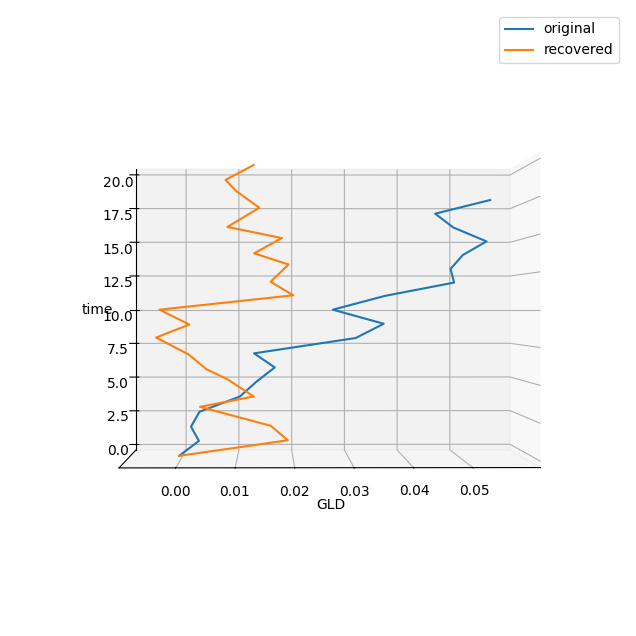

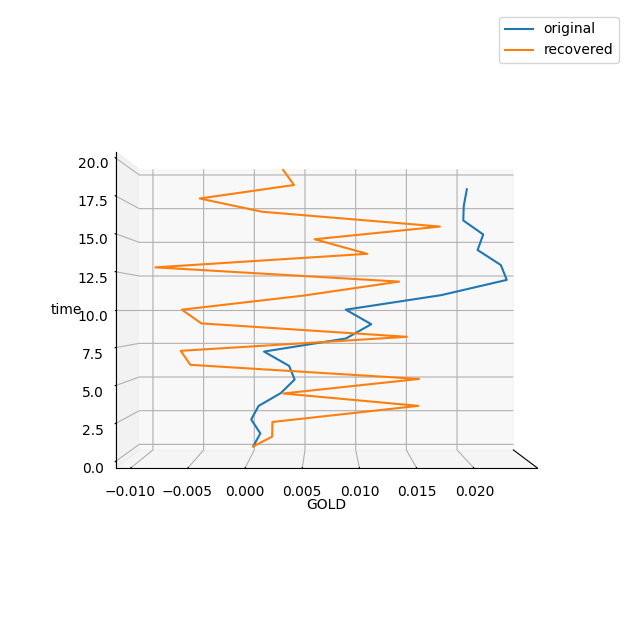

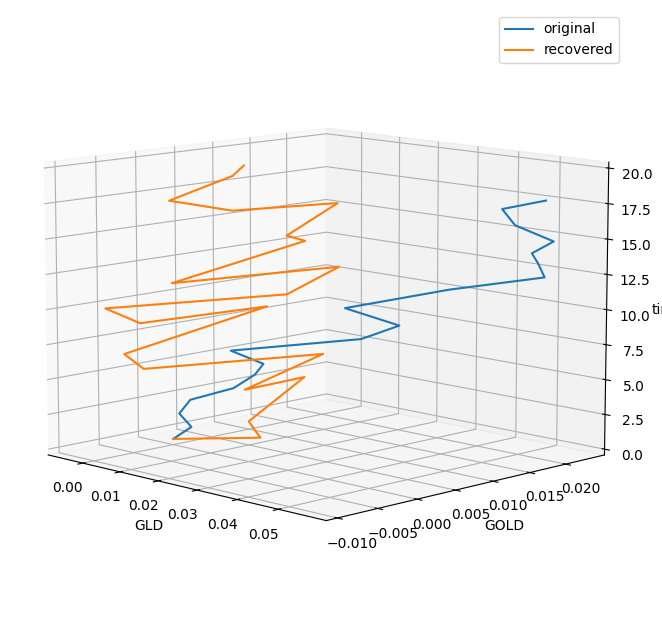

In [59]:
label_x = "GLD"
label_y = "GOLD"

def plotAllProjections3D(filename, path, label_x, label_y, recovered_path=None):
    filename = filename
    plot3D(filename + "_" + label_x + ".png", [True, False], path, 0, -91, label_x, label_y, recovered_path)
    plot3D(filename + "_" + label_y + ".png", [False, True], path, 0, 0, label_x, label_y, recovered_path)
    plot3D(filename + "_" + label_x + "_" + label_y + ".png", [True, True], path, 10, -45, label_x, label_y, recovered_path)

def plot3D(filename, draw_tics, path, elev, azim, label_x, label_y, recovered_path=None):
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev, azim)

    draw_path = path - path[0]
    ax.plot(draw_path[:, 0], draw_path[:, 1], draw_path[:, 2], label='original')

    if (recovered_path is not None):
        draw_recovered_path = recovered_path - recovered_path[0]
        ax.plot(draw_recovered_path[:, 0], draw_recovered_path[:, 1], draw_recovered_path[:, 2], label='recovered')

    if (draw_tics[0]):
        ax.set_xlabel(label_x)
    else:
        ax.set_xticks([])

    if (draw_tics[1]):
        ax.set_ylabel(label_y)
    else:
        ax.set_yticks([])

    ax.set_zlabel("time")

    ax.legend()
    fig.savefig(filename, bbox_inches='tight')

plotAllProjections3D("recover_path", add_time(paths[1]), label_x, label_y, add_time(recovered_path))

In [58]:
print(f"Final loss after recovery: {loss}")


Final loss after recovery: 0.0011035571610995343
